In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:85% !important; }</style>"))

import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.insert(0,'/Users/antonbaleatolizancos/Projects/lensing_rec_biases')
#sys.path.insert(1,'/Users/antonbaleatolizancos/anaconda/envs/lensing_biases_python3_CIBbranch/lib/python3.8/site-packages/')

import numpy as np
import matplotlib.pyplot as plt
from lensing_rec_biases_code import tools as tls
from lensing_rec_biases_code import qest
from lensing_rec_biases_code import biases


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Initialise experiment object

In [2]:
nlev_t = 18. # uK arcmin
beam_size = 1. #arcmin
lmax = 3000 # Maximum ell for the reconstruction
freq_GHz = 143.#217. 

# Initialise experiments with various different mass cuts
SO_5e15 = qest.experiment(6., 1.4, lmax, massCut_Mvir=5e15, freq_GHz=freq_GHz)
SPT_5e15 = qest.experiment(nlev_t, beam_size, lmax, massCut_Mvir=5e15, freq_GHz=freq_GHz)
SPT_5e14 = qest.experiment(nlev_t, beam_size, lmax,  massCut_Mvir=5e14, freq_GHz=freq_GHz)
SPT_1e14 = qest.experiment(nlev_t, beam_size, lmax,  massCut_Mvir=1e14, freq_GHz=freq_GHz)

One can later inspect the properties by doing

In [3]:
print(SPT_5e15)
print(SPT_5e14)
print(SPT_1e14)

Mass Cut: 5.00e+15  lmax: 3000  Beam FWHM: 1.00 Noise (uK arcmin): 18.00  Freq (GHz): 143.00
Mass Cut: 5.00e+14  lmax: 3000  Beam FWHM: 1.00 Noise (uK arcmin): 18.00  Freq (GHz): 143.00
Mass Cut: 1.00e+14  lmax: 3000  Beam FWHM: 1.00 Noise (uK arcmin): 18.00  Freq (GHz): 143.00


Initialise halo model calculator

In [122]:
# This should roughly match the cosmology in Nick's tSZ papers
cosmoParams = {'As':2.4667392631170437e-09,'ns':.96,'omch2':(0.25-.043)*.7**2,'ombh2':0.044*.7**2,'H0':70.} #Note that for now there is still cosmology dpendence in the cls defined within the experiment class

z_max = 5#3
nZs = 10 #50
nMasses = 10 #30

# Set CIB halo model
cib_model='planck13'#'vierro'

# Initialise a halo model object for the calculation, using mostly default parameters
hm_calc = biases.hm_framework(cosmoParams=cosmoParams, nZs=nZs, nMasses=nMasses, cib_model=cib_model, z_max=z_max)

Again, we can print out its properties

In [10]:
print(hm_calc)

M_min: 2.00e+13  M_max: 5.00e+16  n_Masses: 30
  z_min: 0.07  z_max: 5.00  n_zs: 50
  Mass function: sheth-torman  Mass definition: vir


# Calculate the biases

Run the main function for each of the mass cuts, and for either the tsz or cib calculation, using the FFTlog approach

In [22]:
# Calculate secondary bispectrum bias? Note that this is a lot slower that the other implemented terms
get_secondary_bispec_bias = True

#hm_calc.get_tsz_bias(SPT_5e15, get_secondary_bispec_bias=get_secondary_bispec_bias)
hm_calc.get_cib_bias(SPT_5e15, get_secondary_bispec_bias=get_secondary_bispec_bias)

In [6]:
hm_calc.get_tsz_bias(SPT_5e15)
hm_calc.get_tsz_bias(SPT_5e14)
hm_calc.get_tsz_bias(SPT_1e14)

hm_calc.get_cib_bias(SPT_5e15)
hm_calc.get_cib_bias(SPT_5e14)
hm_calc.get_cib_bias(SPT_1e14)

hm_calc.get_mixed_biases(SPT_5e15)
hm_calc.get_mixed_biases(SPT_5e14)
hm_calc.get_mixed_biases(SPT_1e14)

Plot the biases

In [29]:
which_bias = 'cib' # 'tsz' or 'cib' or 'mixed'
experiment = SPT_5e15

# Break down contributions into n-halo terms?
breakdown = False

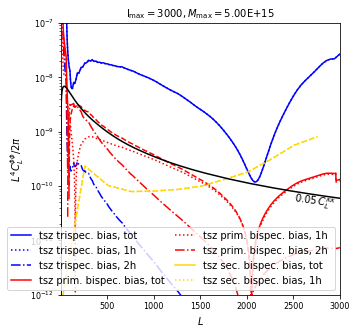

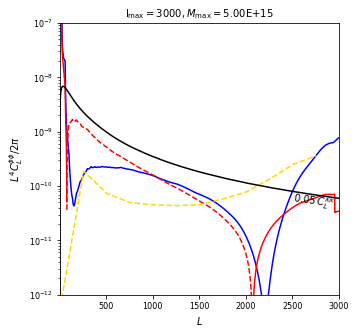

In [30]:
plt.figure(figsize=(5,5))
scaling = experiment.biases['ells']**4 /(2*np.pi)
scaling_second_bispec_bias = experiment.biases['second_bispec_bias_ells']**4 /(2*np.pi)

# Split into negative and positive parts for plotting convenience
prim_bispec_1h_pos, prim_bispec_1h_neg = tls.split_positive_negative(experiment.biases[which_bias]['prim_bispec']['1h'])
prim_bispec_2h_pos, prim_bispec_2h_neg = tls.split_positive_negative(experiment.biases[which_bias]['prim_bispec']['2h'])
prim_bispec_tot_pos, prim_bispec_tot_neg = tls.split_positive_negative(experiment.biases[which_bias]['prim_bispec']['2h']+experiment.biases[which_bias]['prim_bispec']['1h'])

trispec_1h_pos, trispec_1h_neg = tls.split_positive_negative(experiment.biases[which_bias]['trispec']['1h'])
trispec_2h_pos, trispec_2h_neg = tls.split_positive_negative(experiment.biases[which_bias]['trispec']['2h'])
trispec_tot_pos, trispec_tot_neg = tls.split_positive_negative(experiment.biases[which_bias]['trispec']['2h']+ experiment.biases[which_bias]['trispec']['1h'])

sec_bispec_1h_pos, sec_bispec_1h_neg = tls.split_positive_negative(experiment.biases[which_bias]['second_bispec']['1h'])
#FIXME: for now, ony 1h term for secondary bispec bias
sec_bispec_tot_pos, sec_bispec_tot_neg = tls.split_positive_negative ( 0 +experiment.biases[which_bias]['second_bispec']['1h'])


plt.plot(experiment.biases['ells'], scaling * trispec_tot_pos, color='b', label=r'{} trispec. bias, tot '.format(which_bias))
plt.plot(experiment.biases['ells'], scaling * trispec_tot_neg, color='b', ls='--')

if breakdown:
    title='_withbreakdown'
    plt.plot(experiment.biases['ells'], scaling * trispec_1h_pos, color='b', label=r'{} trispec. bias, 1h '.format(which_bias), ls=':')
    plt.plot(experiment.biases['ells'], scaling * trispec_1h_neg, color='b', ls=':')

    plt.plot(experiment.biases['ells'], scaling * trispec_2h_pos, color='b', label=r'{} trispec. bias, 2h '.format(which_bias), ls='-.')
    plt.plot(experiment.biases['ells'], scaling * trispec_2h_neg, color='b', ls='-.')

plt.plot(experiment.biases['ells'], scaling * prim_bispec_tot_pos, color='r',label=r'{} prim. bispec. bias, tot'.format(which_bias))
plt.plot(experiment.biases['ells'], scaling * prim_bispec_tot_neg, color='r', ls='--')

if breakdown:
    plt.plot(experiment.biases['ells'], scaling * prim_bispec_1h_pos, color='r', label=r'{} prim. bispec. bias, 1h '.format(which_bias), ls=':')
    plt.plot(experiment.biases['ells'], scaling * prim_bispec_1h_neg, color='r', ls=':')

    plt.plot(experiment.biases['ells'], scaling * prim_bispec_2h_pos, color='r', label=r'{} prim. bispec. bias, 2h '.format(which_bias), ls='-.')
    plt.plot(experiment.biases['ells'], scaling * prim_bispec_2h_neg, color='r', ls='-.')
    
plt.plot(experiment.biases['second_bispec_bias_ells'], scaling_second_bispec_bias * sec_bispec_tot_pos, color='gold',label=r'{} sec. bispec. bias, tot'.format(which_bias))
plt.plot(experiment.biases['second_bispec_bias_ells'], scaling_second_bispec_bias * sec_bispec_tot_neg, color='gold', ls='--')

if breakdown:
    plt.plot(experiment.biases['second_bispec_bias_ells'], scaling_second_bispec_bias * sec_bispec_1h_pos, color='gold', label=r'{} sec. bispec. bias, 1h '.format(which_bias), ls=':')
    plt.plot(experiment.biases['second_bispec_bias_ells'], scaling_second_bispec_bias * sec_bispec_1h_neg, color='gold', ls=':')

    #plt.plot(experiment.biases['second_bispec_bias_ells'], scaling_second_bispec_bias * sec_bispec_2h_pos, color='gold', label=r'{} sec. bispec. bias, 2h '.format(which_bias), ls='-.')
    #plt.plot(experiment.biases['second_bispec_bias_ells'], scaling_second_bispec_bias * sec_bispec_2h_neg, color='gold', ls='-.')
    
plt.annotate(r'$0.05\,C_L^{\kappa \kappa}$', (2500,4e-11), rotation=-8)
plt.plot(experiment.cl_unl.ls, 0.05* experiment.cl_unl.ls**4 * experiment.cl_unl.clpp /(2*np.pi),'k')
plt.yscale('log')
#plt.legend(ncol=1, columnspacing=1)
plt.ylabel(r'$L^4 C_L^{\phi\phi}/ 2\pi$',fontsize=10)
plt.xlabel(r'$L$',fontsize=10)
plt.title(r'l$_{\mathrm{max}}=$'+str(lmax)+'$, M_{\mathrm{max}}=$'+'{:.2E}'.format(experiment.massCut), fontsize=10)
plt.xlim([2,3000])
plt.ylim([1e-12,1e-7])

ax = plt.gca()
ax.tick_params(axis='both', which='major', labelsize=8)
ax.tick_params(axis='both', which='minor', labelsize=8)

#plt.savefig('../plots/tsz_bias_for_diff_mass_cuts/1D_reconstructions/biases_lmax{}_masscut{}.pdf'.format(lmax, '1e14'))
thesis_dir = '/Users/antonbaleatolizancos/Desktop/THESIS/phd_thesis/Chapter4/plots_lensing_rec_biases/'

if get_secondary_bispec_bias:
    plt.savefig(thesis_dir+'{}_biases_cosmoblender_lmax{}{}_withsecbispecbias.pdf'.format(which_bias, lmax, title), bbox_inches='tight')
else:
    plt.savefig(thesis_dir+'{}_biases_cosmoblender_lmax{}{}.pdf'.format(which_bias, lmax, title), bbox_inches='tight')

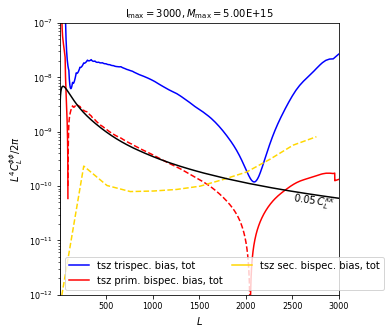

We can save the dictionary of biases to file as

In [ ]:
experiment.save_biases()

and later retrieve them as

In [17]:
dict_of_biases = qest.load_dict_of_biases()

Successfully loaded experiment object with properties:

{'ells': array([   0,    1,    2, ..., 2998, 2999, 3000]), 'second_bispec_bias_ells': {}, 'tsz': {'trispec': {'1h': array([0.00000000e+00 +0.j,            nan+nanj,            nan+nanj, ...,
       3.54694509e-21 +0.j, 3.55447583e-21 +0.j, 3.56201459e-21 +0.j]), '2h': array([0.00000000e+00+0.00000000e+00j,            nan           +nanj,
                  nan           +nanj, ...,
       6.74863855e-26+1.17366872e-43j, 6.75751100e-26+1.17521174e-43j,
       6.76638130e-26+1.17675439e-43j])}, 'prim_bispec': {'1h': array([           nan           +nanj,            nan           +nanj,
                  nan           +nanj, ...,
       2.10476640e-23+1.83021988e-41j, 2.10468358e-23+1.83014786e-41j,
       2.10459905e-23+1.83007436e-41j]), '2h': array([            nan           +nanj, 6.33500117e+301+0.00000000e+00j,
       2.99655862e+301+0.00000000e+00j, ...,
       5.80663780e-025+5.04921778e-43j, 5.80417792e-025+5.04707876e-43j,
 

We can also use the standard Quicklens implementation of the QEs instead of FFTlog

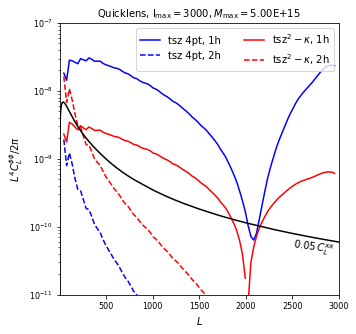

In [11]:
plt.figure(figsize=(5,5))
scaling = experiment.biases['ells']**4 /(2*np.pi)

flat_sky_correction = 1

plt.plot(experiment.biases['ells'][experiment.biases[which_bias]['trispec']['1h']>0],flat_sky_correction**2 *(scaling * experiment.biases[which_bias]['trispec']['1h'])[experiment.biases[which_bias]['trispec']['1h']>0],color='b',label=r'{} 4pt, 1h '.format(which_bias))

plt.plot(experiment.biases['ells'][experiment.biases[which_bias]['trispec']['2h']>0],flat_sky_correction**2 *(scaling * experiment.biases[which_bias]['trispec']['2h'])[experiment.biases[which_bias]['trispec']['2h']>0],color='b',label=r'{} 4pt, 2h '.format(which_bias),ls='--')
plt.plot(experiment.biases['ells'][experiment.biases[which_bias]['trispec']['2h']<0],-flat_sky_correction**2 *(scaling * experiment.biases[which_bias]['trispec']['2h'])[experiment.biases[which_bias]['trispec']['2h']<0],color='b',ls='--')

plt.plot(experiment.biases['ells'][experiment.biases[which_bias]['prim_bispec']['1h']>0],flat_sky_correction *(scaling *experiment.biases[which_bias]['prim_bispec']['1h'])[experiment.biases[which_bias]['prim_bispec']['1h']>0],color='r',label=r'{}$^2-\kappa$, 1h'.format(which_bias))
plt.plot(experiment.biases['ells'][experiment.biases[which_bias]['prim_bispec']['1h']<0],-flat_sky_correction*(scaling *experiment.biases[which_bias]['prim_bispec']['1h'])[experiment.biases[which_bias]['prim_bispec']['1h']<0],color='r')

plt.plot(experiment.biases['ells'][experiment.biases[which_bias]['prim_bispec']['2h']>0],flat_sky_correction*(scaling *experiment.biases[which_bias]['prim_bispec']['2h'])[experiment.biases[which_bias]['prim_bispec']['2h']>0],color='r',label=r'{}$^2-\kappa$, 2h'.format(which_bias),ls='--')
plt.plot(experiment.biases['ells'][experiment.biases[which_bias]['prim_bispec']['2h']<0],-flat_sky_correction*(scaling *experiment.biases[which_bias]['prim_bispec']['2h'])[experiment.biases[which_bias]['prim_bispec']['2h']<0],color='r',ls='--')

plt.annotate(r'$0.05\,C_L^{\kappa \kappa}$', (2500,4e-11), rotation=-8)
plt.plot(experiment.cl_unl.ls, 0.05* experiment.cl_unl.ls**4 * experiment.cl_unl.clpp /(2*np.pi),'k')
plt.yscale('log')
plt.legend(fontsize=10, ncol=2)
plt.ylabel(r'$L^4 C_L^{\phi\phi}/ 2\pi$',fontsize=10)
plt.xlabel(r'$L$',fontsize=10)
plt.title(r'Quicklens, l$_{\mathrm{max}}=$'+str(lmax)+'$, M_{\mathrm{max}}=$'+'{:.2E}'.format(experiment.massCut), fontsize=10)
plt.xlim([2,3000])
plt.ylim([1e-11,1e-7])

ax = plt.gca()
ax.tick_params(axis='both', which='major', labelsize=8)
ax.tick_params(axis='both', which='minor', labelsize=8)

#plt.savefig('../plots/tsz_bias_for_diff_mass_cuts/1D_reconstructions/biases_lmax{}_masscut{}.pdf'.format(lmax, '1e14'))


# Test the FFTlog implementation of the QE

We now test the FFTlog implementation of the 1D TT QE against a brute-force calculation of the integrals

Generate a y profile

In [10]:
y = tls.pkToPell(hm_calc.hcos.comoving_radial_distance(hm_calc.hcos.zs[1]),hm_calc.hcos.ks,\
                 hm_calc.hcos.pk_profiles['y'][1,1]*(1-np.exp(-(hm_calc.hcos.ks/hm_calc.hcos.p['kstar_damping']))), ellmax=SPT.lmax)

Calculate the (unnormalised) lensing reconstruction by brute force (this can be very slow)

In [11]:
output_ells = np.linspace(20, 3000, 10)

unnorm_rec_bruteforce = SPT.get_brute_force_unnorm_TT_qe(output_ells,y)

dealing with integrable singularity by setting to 0
dealing with integrable singularity by setting to 0
dealing with integrable singularity by setting to 0
dealing with integrable singularity by setting to 0
dealing with integrable singularity by setting to 0
dealing with integrable singularity by setting to 0
dealing with integrable singularity by setting to 0
dealing with integrable singularity by setting to 0
dealing with integrable singularity by setting to 0
dealing with integrable singularity by setting to 0
dealing with integrable singularity by setting to 0
dealing with integrable singularity by setting to 0
dealing with integrable singularity by setting to 0


Now calculate it using FFTlog

In [101]:
output_ells_refined =  np.arange(3000)

# FFTlog parameters
N_l= 2*4096#2*4096
lmin= .000135 #0.000135
alpha= -1.35#-1.35

unnorm_rec_fftlog = SPT.get_unnorm_TT_qe(output_ells_refined,y, N_l=N_l, lmin=lmin, alpha=alpha)

Compare the two

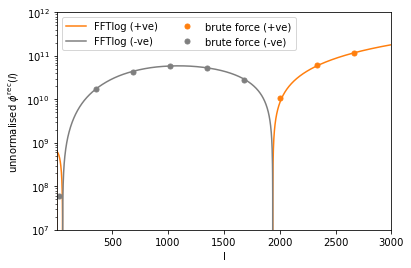

In [102]:
plt.semilogy(output_ells_refined, unnorm_rec_fftlog, color='tab:orange', label='FFTlog (+ve)')
plt.semilogy(output_ells_refined, - unnorm_rec_fftlog, color='tab:gray', label='FFTlog (-ve)')

plt.semilogy(output_ells, unnorm_rec_bruteforce, marker='o', lw=0, markersize=5, color='tab:orange', label='brute force (+ve)')
plt.semilogy(output_ells, -unnorm_rec_bruteforce, marker='o', markersize=5, lw=0, color='tab:gray', label='brute force (-ve)')

plt.xlim([1, 3000])
plt.ylim([1e7, 1e12])
plt.xlabel('l')
plt.ylabel(r'unnormalised $\phi^{\mathrm{rec}} (l)$')
plt.legend(loc='upper left', ncol=2)


# Calculate the biases to B-mode delensing

In [170]:
SO_5e15 = qest.experiment(6., 1.5, 3000, massCut_Mvir=5e15, freq_GHz=freq_GHz)
SO_1e15 = qest.experiment(6., 1.5, 3000, massCut_Mvir=1e15, freq_GHz=freq_GHz)
SO_5e14 = qest.experiment(6., 1.5, 3000, massCut_Mvir=5e14, freq_GHz=freq_GHz)

(-1e-07, 1.5e-07)

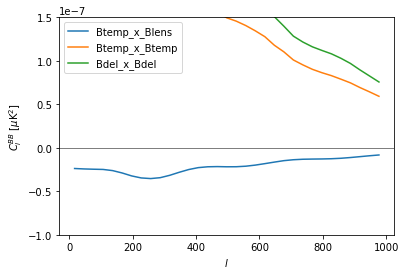

In [171]:
ells, cl_Btemp_x_Blens_bias, cl_Btemp_x_Btemp_bias, cl_Bdel_x_Bdel_bias = hm_calc.get_bias_to_delensed_clbb(SO_5e15)

plt.plot(ells, cl_Btemp_x_Blens_bias, label=r'Btemp_x_Blens')
plt.plot(ells, cl_Btemp_x_Btemp_bias, label=r'Btemp_x_Btemp')
plt.plot(ells, cl_Bdel_x_Bdel_bias, label=r'Bdel_x_Bdel')
plt.ylabel(r'$C_l^{BB}$ [$\mu$K$^2$]')
plt.xlabel(r'$l$')
plt.legend()
plt.axhline(0, color='k', lw=0.5)
plt.ylim([-1e-7,1.5e-7])

(-1e-07, 1.5e-07)

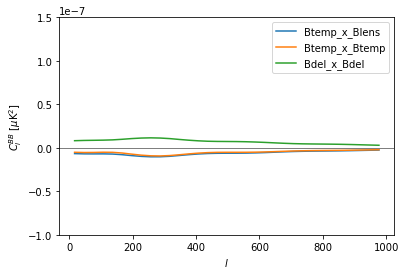

In [172]:
ells, cl_Btemp_x_Blens_bias_SO_1e15, cl_Btemp_x_Btemp_bias_SO_1e15, cl_Bdel_x_Bdel_bias_SO_1e15 = hm_calc.get_bias_to_delensed_clbb(SO_5e14)

plt.plot(ells, cl_Btemp_x_Blens_bias_SO_1e15, label=r'Btemp_x_Blens')
plt.plot(ells, cl_Btemp_x_Btemp_bias_SO_1e15, label=r'Btemp_x_Btemp')
plt.plot(ells, cl_Bdel_x_Bdel_bias_SO_1e15, label=r'Bdel_x_Bdel')
plt.ylabel(r'$C_l^{BB}$ [$\mu$K$^2$]')
plt.xlabel(r'$l$')
plt.legend()
plt.axhline(0, color='k', lw=0.5)
plt.ylim([-1e-7,1.5e-7])

(-1e-07, 1.5e-07)

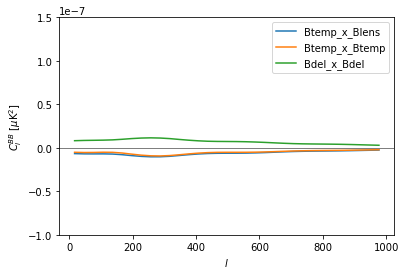

In [173]:
ells, cl_Btemp_x_Blens_bias_SO_5e14, cl_Btemp_x_Btemp_bias_SO_5e14, cl_Bdel_x_Bdel_bias_SO_5e14 = hm_calc.get_bias_to_delensed_clbb(SO_5e14)

plt.plot(ells, cl_Btemp_x_Blens_bias_SO_5e14, label=r'Btemp_x_Blens')
plt.plot(ells, cl_Btemp_x_Btemp_bias_SO_5e14, label=r'Btemp_x_Btemp')
plt.plot(ells, cl_Bdel_x_Bdel_bias_SO_5e14, label=r'Bdel_x_Bdel')
plt.ylabel(r'$C_l^{BB}$ [$\mu$K$^2$]')
plt.xlabel(r'$l$')
plt.legend()
plt.axhline(0, color='k', lw=0.5)
plt.ylim([-1e-7,1.5e-7])